<a href="https://colab.research.google.com/github/Hrithik2212/PyTorch-Deep-Learning-/blob/main/05_Transfer_Learning_for_custom_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning 

## Data Wrangling 

In [2]:
import requests 
import zipfile 
from pathlib import Path 
data_path = Path('data/')
img_path = data_path /'pizza_steak_sushi'
if img_path.is_dir():
  print(f'Image Path exists ')
else :
  print(f'Image Path does not exist')
  print(f'Downloading Data')
  img_path.mkdir(parents=True , exist_ok=True)
  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(img_path)

Image Path does not exist
Unzipping pizza, steak, sushi data...


In [3]:
import os 
def walk_through_dir(dir_path):
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} in {dirpath}')
walk_through_dir('/content/data')

There are 1 directories and 1 in /content/data
There are 2 directories and 0 in /content/data/pizza_steak_sushi
There are 3 directories and 0 in /content/data/pizza_steak_sushi/test
There are 0 directories and 19 in /content/data/pizza_steak_sushi/test/steak
There are 0 directories and 31 in /content/data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 in /content/data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 in /content/data/pizza_steak_sushi/train
There are 0 directories and 75 in /content/data/pizza_steak_sushi/train/steak
There are 0 directories and 72 in /content/data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 in /content/data/pizza_steak_sushi/train/pizza


In [4]:
train_dir = img_path / 'train'
test_dir = img_path / 'test'
train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Data Preparations

In [5]:
## imports 
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.0+cu113
torchvision version: 0.13.0+cu113


In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 2730, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 2730 (delta 99), reused 192 (delta 96), pack-reused 2532
Receiving objects: 100% (2730/2730), 454.40 MiB | 36.42 MiB/s, done.
Resolving deltas: 100% (1536/1536), done.
Checking out files: 100% (194/194), done.


In [7]:
# Device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [25]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [26]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc9606d4450>,
 ['pizza', 'steak', 'sushi'])

## Setting Up PreTrained Model

In [36]:
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)
model_0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [37]:
# Getting a summary of the model with torchinfo.summary()
summary(model = model_0,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [38]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False


In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [40]:
summary(model_0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train Model 

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=8,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8394 | train_acc: 0.6562 | test_loss: 0.5105 | test_acc: 0.7225
Epoch: 2 | train_loss: 0.5733 | train_acc: 0.7305 | test_loss: 0.3235 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.2561 | train_acc: 0.9141 | test_loss: 0.4280 | test_acc: 0.7746
Epoch: 4 | train_loss: 0.4272 | train_acc: 0.8477 | test_loss: 0.3117 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5394 | train_acc: 0.7695 | test_loss: 0.4713 | test_acc: 0.8144
Epoch: 6 | train_loss: 0.5944 | train_acc: 0.8477 | test_loss: 0.4423 | test_acc: 0.7841
Epoch: 7 | train_loss: 0.1498 | train_acc: 0.9844 | test_loss: 0.3643 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.5886 | train_acc: 0.7930 | test_loss: 0.4357 | test_acc: 0.8456
[INFO] Total training time: 20.919 seconds


## Evaluate Model 

[INFO] Couldn't find helper_functions.py, downloading...


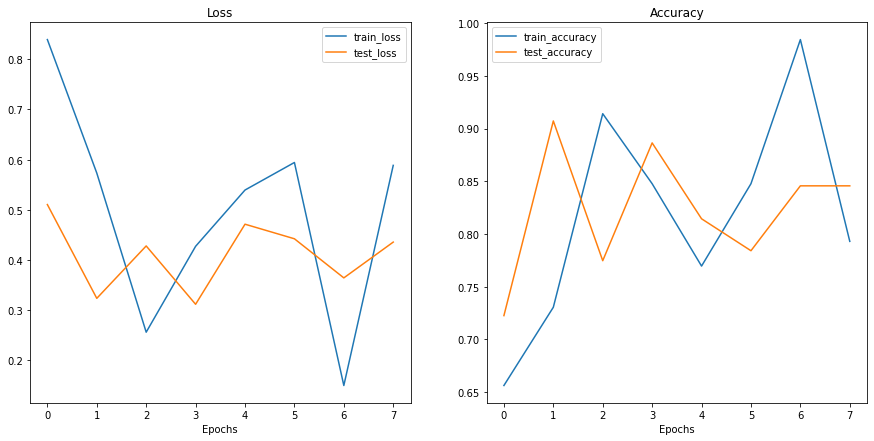

In [43]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)
